In [1]:
import gymnasium as gym
import pandas as pd
import time
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import joblib
import numpy as np
from stable_baselines3 import A2C
from env.flo_portfolio import FlorianPortfolioEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import ProgressBarCallback,CallbackList, EvalCallback
from models.callbacks import CustomCallBack, HParamCallback
from models.models import DRLAgent
from gymnasium import spaces
from pyfolio import timeseries
import pyfolio
from plot.plot import convert_daily_return_to_pyfolio_ts, convert_account_value_to_pyfolio_ts, get_baseline, backtest_stats, get_daily_return
from hyperopt.optunaoptimizer import optimize_optuna

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



ModuleNotFoundError: No module named 'hyperopt.optunaoptimizer'

In [ ]:
df = pd.read_csv('/Users/floriankockler/My Drive/SPX_2.csv', skiprows=6).dropna(axis=0)
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
df

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,MA20,tic
1,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,349.39,SPX
2,1990-01-04,355.67,358.74,352.89,358.76,58.72,61.98,56.59,332.52,344.49,349.69,SPX
3,1990-01-05,352.20,355.65,351.35,355.67,52.64,58.36,35.17,332.83,344.66,349.88,SPX
4,1990-01-08,353.79,352.19,350.54,354.24,54.94,59.48,48.55,333.16,344.89,350.19,SPX
5,1990-01-09,349.62,353.83,349.61,354.17,48.31,55.43,26.79,333.45,345.12,350.23,SPX
...,...,...,...,...,...,...,...,...,...,...,...,...
8450,2023-07-19,4565.72,4563.87,4557.48,4578.43,75.00,67.61,94.86,4043.67,4311.72,4435.98,SPX
8451,2023-07-20,4534.87,4554.38,4527.56,4564.74,67.94,64.81,53.04,4048.41,4319.65,4444.44,SPX
8452,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,4452.17,SPX
8453,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,4462.48,SPX


In [ ]:
train_start = "1990-01-03"
train_end = "2015-12-31"
validate_start = "2016-01-01"
validate_end = "2020-12-31"
test_start = "12021-01-01"
test_end = "2023-07-25"

In [ ]:
def data_split(df, start, end, target_date_col="date"):
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data

In [ ]:
train = data_split(df, train_start, train_end)
validate = data_split(df, validate_start, validate_end)

In [ ]:
# stock_dimension = len(train.tic.unique())
# state_space = stock_dimension

In [ ]:
df.columns

Index(['date', 'close', 'open', 'low', 'high', 'RSI14', 'RSI30', 'RSI3',
       'MA200', 'MA50', 'MA20', 'tic'],
      dtype='object')

In [ ]:
indicators = ['RSI14', 'RSI30', 'RSI3','MA200', 'MA50', 'MA20']
stock_dimension = len(train.tic.unique())
state_space = 1+2*stock_dimension + len(indicators)
additional_price_info= ['open', 'low', 'high']
env_kwargs = {
    "initial_amount": 1000000, 
    "trade_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "indicators": indicators, 
    "action_space": stock_dimension,
    "short_selling_allowed": False,
    "take_leverage_allowed": False,
    "reward_scaling": 1e-4, # the magnitude of rewards can significantly affect the learning process. If the rewards are too large, they can cause the learning algorithm to become unstable. On the other hand, if the rewards are too small, the agent might not learn effectively because the rewards don't provide a strong enough signal.
    "hmax": 100, #that should be increased when trading SPX
    # Not for optimization
    "make_plots": False,
    "num_stock_shares": [50], #number of initioal shares
    "model_name": "A-2C",
    "mode": "training", #can be anything, just for plots
    "iteration": "1000"#can be anything, just for plots
    
}




In [ ]:

#initate env
env = FlorianPortfolioEnv(df=train, **env_kwargs)
# check_env(env, warn=True)

In [ ]:
#EvalCallback: Evaluate periodically the performance of an agent, using a separate test environment. It will save the best model if best_model_save_path folder is specified and save the evaluations results in a numpy archive (evaluations.npz) if log_path folder is specified.
eval_callback = EvalCallback(eval_env=env, best_model_save_path="./logs/", eval_freq=500, deterministic=True, render=False)
progress_callback = ProgressBarCallback()
params_callback = HParamCallback()


In [ ]:
#Chaining Callbacks
callbacks = CallbackList([eval_callback,progress_callback, params_callback ])

In [ ]:
env_train = FlorianPortfolioEnv(df=train, **env_kwargs)
env_validate = FlorianPortfolioEnv(df=validate, **env_kwargs)

        
optimize_optuna(env_train, env_validate, callbacks, n_trial_runs=2)

In [ ]:

#Define and Train the agend
# model = A2C('MlpPolicy', env, verbose=0, tensorboard_log="./tensorboard/a2c_florian/")
# model.learn(total_timesteps=50000, callback=callbacks, tb_log_name="a2c_florian_any_name")
# Once the learn function is called, you can monitor the RL agent during or after the training, with the following bash command:
# tensorboard --logdir ./a2c_cartpole_tensorboard/

In [ ]:
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model = A2C('MlpPolicy', env, verbose=0, tensorboard_log="./tensorboard/a2c_florian/", **A2C_PARAMS)
# trained_model = model.learn(total_timesteps=100000, callback=callbacks, tb_log_name="a2c_florian_any_name")


Output()

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

New best mean reward!

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 10

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=1000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=1500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Sharpe: 0.478

=================================

Eval num_timesteps=2000, episode_reward=513.07 +/- 0.00

Episode length: 6551.00 +/- 0.00

New best mean reward!

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 30

begin_total_asset: 1017938.00

end_total_asset: 5715374.84

total_reward: 4697436.84

total_cost: 1312.00

total_trades: 2518

Sharpe: 0.465

=================================

Eval num_timesteps=2500, episode_reward=467.38 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=3000, episode_reward=432.75 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 40

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=3500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=4000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 50

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=4500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 60

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=5000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=5500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 70

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=6000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=6500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 80

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=7000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 90

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=7500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=8000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 100

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=8500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=9000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 110

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=9500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 120

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=10000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=10500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 130

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=11000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=11500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 140

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=12000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 150

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=12500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=13000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 160

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=13500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=14000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 170

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=14500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 180

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=15000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=15500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 190

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=16000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=16500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 200

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=17000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 210

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=17500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=18000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 220

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=18500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=19000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 230

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=19500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 240

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=20000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=20500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 250

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=21000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

Eval num_timesteps=21500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 260

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=22000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 270

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=22500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=23000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 280

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=23500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=24000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 290

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=24500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 300

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=25000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=25500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 310

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=26000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 320

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 330

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=27500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=28000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 340

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=28500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=29000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 350

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 360

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=30000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=30500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 370

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=31000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=31500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 380

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=32000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 390

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=32500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=33000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 400

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=33500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=34000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 410

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=34500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 420

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=35000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=35500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 430

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=36000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=36500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 440

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=37000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 450

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=37500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=38000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 460

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=38500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=39000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 470

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=39500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 480

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=40000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=40500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 490

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=41000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=41500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 500

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=42000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 510

Sharpe: -0.196

=================================

Eval num_timesteps=42500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=43000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 520

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=43500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=44000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 530

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=44500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 540

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=45000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=45500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 550

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=46000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=46500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 560

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=47000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 570

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=47500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=48000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 580

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=48500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=49000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 590

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=49500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 600

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=50000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=50500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 610

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=51000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=51500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 620

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=52000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 630

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=52500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=53000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 640

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=53500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=54000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 650

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=54500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 660

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=55000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=55500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 670

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=56000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=56500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 680

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=57000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 690

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=57500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=58000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 700

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=58500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=59000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 710

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=59500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 720

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=60000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=60500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 730

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=61000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=61500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 740

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Eval num_timesteps=62000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 750

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=62500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=63000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 760

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=64000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 770

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=64500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 780

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=65000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=65500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 790

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=66000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=66500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 800

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Eval num_timesteps=67000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 810

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=67500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=68000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 820

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=68500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=69000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 830

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=69500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 840

Eval num_timesteps=70000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=70500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 850

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=71000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=71500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 860

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=72000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 870

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=73000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 880

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=73500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=74000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 890

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=74500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 900

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=75500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 910

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=76500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 920

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=77000, episode_reward=0.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 930

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=77500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=78000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 940

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=78500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=79000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 950

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=79500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 960

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=80000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=80500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 970

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=81000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=81500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 980

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=82000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 990

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=82500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=83000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1000

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=83500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=84000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1010

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1020

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=85000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=85500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1030

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=86000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=86500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1040

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=87000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1050

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=87500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=88000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1060

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=88500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Eval num_timesteps=89000, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

day: 6550, episode: 1070

begin_total_asset: 1017938.00

end_total_asset: 1000000.00

total_reward: -17938.00

total_cost: 0.00

total_trades: 6550

Sharpe: -0.196

=================================

Eval num_timesteps=89500, episode_reward=0.00 +/- 0.00

Episode length: 6551.00 +/- 0.00

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

KeyboardInterrupt: 

Trading

In [ ]:
test = data_split(df,test_start, test_end)
env_trade = FlorianPortfolioEnv(df=test, **env_kwargs)

In [ ]:
df_account_memory, df_actions, df_daily_return = DRLAgent.DRL_prediction_flo(model=trained_model,
                        environment = env_trade)

hit end!


<Axes: >

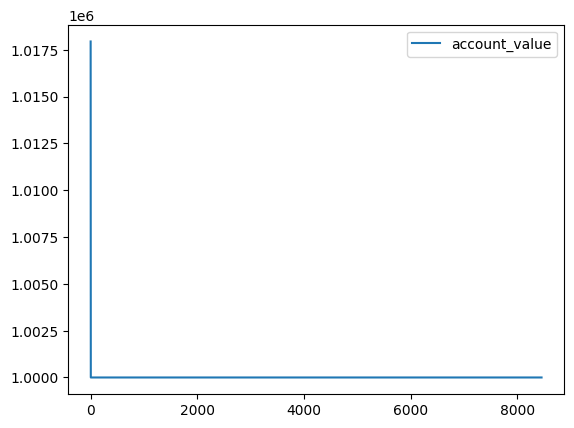

In [ ]:
df_account_memory

In [ ]:
df_daily_return

,date,daily_return
0,1990-01-03,0.0
1,1990-01-04,0.0
2,1990-01-05,0.0
3,1990-01-08,0.0
4,1990-01-09,0.0
...,...,...
8448,2023-07-18,0.0
8449,2023-07-19,0.0
8450,2023-07-20,0.0
8451,2023-07-21,0.0


In [ ]:
df_actions

,date,actions
0,1990-01-03,[0]
1,1990-01-04,[0]
2,1990-01-05,[0]
3,1990-01-08,[0]
4,1990-01-09,[0]
...,...,...
8447,2023-07-17,[0]
8448,2023-07-18,[0]
8449,2023-07-19,[0]
8450,2023-07-20,[0]


In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:1412: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))


In [ ]:
df_daily_return

,date,daily_return
0,1990-01-03,0.0
1,1990-01-04,0.0
2,1990-01-05,0.0
3,1990-01-08,0.0
4,1990-01-09,0.0
...,...,...
8448,2023-07-18,0.0
8449,2023-07-19,0.0
8450,2023-07-20,0.0
8451,2023-07-21,0.0


In [ ]:
perf_stats_all

Annual return          0.0
Cumulative returns     0.0
Annual volatility      0.0
Sharpe ratio           NaN
Calmar ratio           NaN
Stability              0.0
Max drawdown           0.0
Omega ratio            NaN
Sortino ratio          NaN
Skew                   NaN
Kurtosis               NaN
Tail ratio             NaN
Daily value at risk    0.0
Alpha                  NaN
Beta                   NaN
dtype: float64

In [ ]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^SPX", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8452, 8)
Annual return           0.078583
Cumulative returns     11.644497
Annual volatility       0.182350
Sharpe ratio            0.506299
Calmar ratio            0.138411
Stability               0.873883
Max drawdown           -0.567754
Omega ratio             1.100300
Sortino ratio           0.715581
Skew                         NaN
Kurtosis                     NaN
Tail ratio              0.950741
Daily value at risk    -0.022608
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (8453, 8)


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/empyrical/stats.py:1412: RuntimeWarning: invalid value encountered in scalar divide
  return np.abs(np.percentile(returns, 95)) / np.abs(np.percentile(returns, 5))


Start date,1990-01-03
End date,2023-07-24
Total months,402
,Backtest
Annual return,0.0%
Cumulative returns,0.0%
Annual volatility,0.0%
Sharpe ratio,NaN
Calmar ratio,NaN
Stability,0.00
Max drawdown,0.0%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,1990-01-03,1990-01-03,1990-01-03,1
1,NaN,NaT,NaT,NaT,NaN
2,NaN,NaT,NaT,NaT,NaN
3,NaN,NaT,NaT,NaT,NaN
4,NaN,NaT,NaT,NaT,NaN


ConversionError: Failed to convert value(s) to axis units: (NaT, Timestamp('2023-07-24 00:00:00+0000', tz='UTC'))

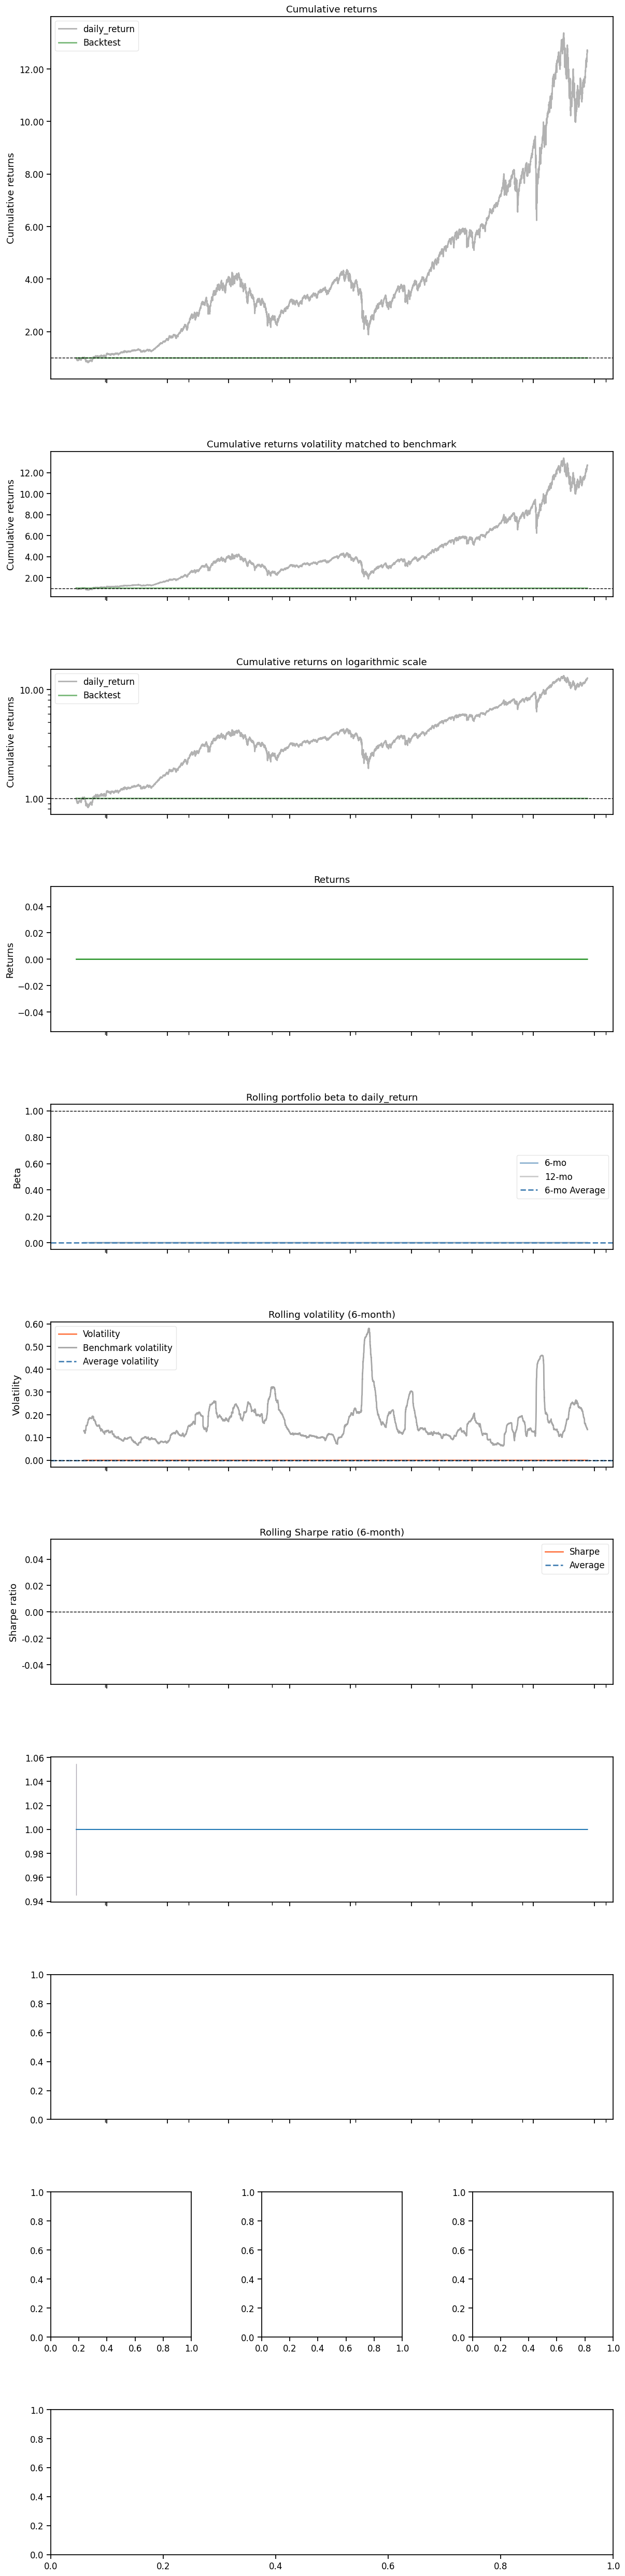

In [ ]:
%matplotlib inline
baseline_df = get_baseline(
        ticker='^SPX', start=df_daily_return.loc[0,'date'], end=test_end
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
        
                                       benchmark_rets=baseline_returns, set_context=False)
